In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt

# suppress warning
import warnings
warnings.filterwarnings('ignore')

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

#from IPython.display import Image

import seaborn as sns
sns.set()

%matplotlib inline

In [ ]:
!pip install statsmodels --upgrade

In [2]:
bart = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv')

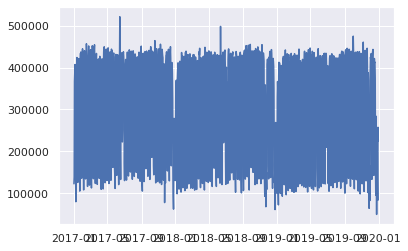

In [3]:
bart['date'] = pd.to_datetime(bart['date'])
plt.plot(bart['date'],bart['passenger']);

Task 1: use linear regression to explore the trends over 3 years, and report if there is a significant trend in the BART data.

Hint: use the index to represent the day count from the first day of the period.

In [ ]:
bart = bart.set_index('date')
bart.head()

,passenger
date,
2017-01-01,122773
2017-01-02,139245
2017-01-03,366495
2017-01-04,388842
2017-01-05,407099


In [ ]:
lm=sm.OLS(bart['passenger'],sm.add_constant(bart.index.year)).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.493
Date:                Mon, 21 Feb 2022   Prob (F-statistic):              0.222
Time:                        04:14:07   Log-Likelihood:                -14433.
No. Observations:                1095   AIC:                         2.887e+04
Df Residuals:                    1093   BIC:                         2.888e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.205e+07   9.59e+06      1.256      0.2

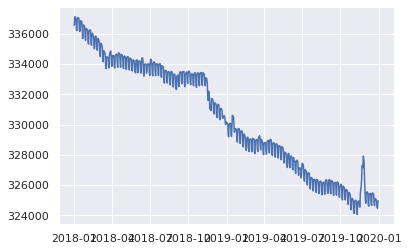

In [ ]:
plt.plot(bart.rolling(window = 365).mean())

Task 2: Find a proper period using scipy.signal.periodogram and autocorrelation

In [ ]:
bart[:365]
bart[365:730]
bart[730:]

,date,passenger
730,2019-01-01,100098
731,2019-01-02,329733
732,2019-01-03,366644
733,2019-01-04,342706
734,2019-01-05,113495
...,...,...
1090,2019-12-27,229101
1091,2019-12-28,136422
1092,2019-12-29,83354
1093,2019-12-30,257428


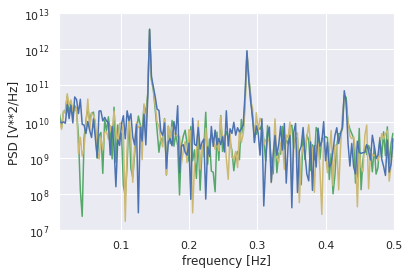

Strongest period green = 7.019230769230769
Strongest period yellow = 7.019230769230769
Strongest period blue = 7.019230769230769


In [ ]:
f, PSD = scipy.signal.periodogram(bart.passenger[:365])
f2, PSD2 = scipy.signal.periodogram(bart.passenger[365:730])
f3, PSD3 = scipy.signal.periodogram(bart.passenger[730:])
plt.semilogy(f, PSD, 'g')
plt.semilogy(f2, PSD2, 'y')
plt.semilogy(f3, PSD3, 'b')
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.xlim(0.01,0.5)
plt.ylim(1e7,1e13)
plt.show()
PSD = PSD[f>0.01]; f = f[f>0.01]
PSD2 = PSD2[f2>0.01]; f2 = f2[f2>0.01]
PSD3 = PSD3[f3>0.01]; f3 = f3[f3>0.01]
print('Strongest period green = {}'.format(1/f[np.argmax(PSD)]))
print('Strongest period yellow = {}'.format(1/f2[np.argmax(PSD2)]))
print('Strongest period blue = {}'.format(1/f3[np.argmax(PSD3)]))

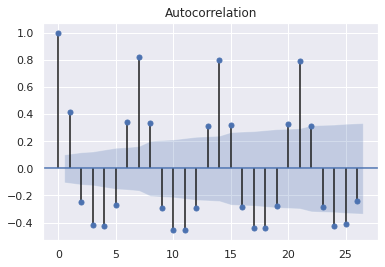

In [ ]:
#plot_acf(bart.passenger[:365])
#plot_acf(bart.passenger[365:730])
#plot_acf(bart.passenger[730:])

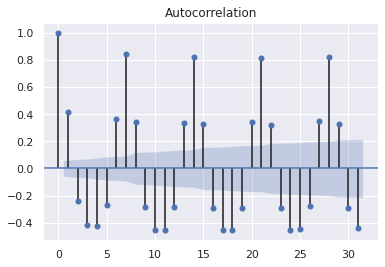

In [ ]:
plot_acf(bart)
plt.show()

Task 3: Build a linear regression for trend+seasonality (using a weekly period with 7 dummy variables for each day of the week) to predict passenger count. Train on 2017 and 2018, test on 2019. Visualize the coefficients for each day of the week and analyze their significance

In [5]:
bart['DOW'] = pd.to_datetime(bart.date).dt.dayofweek
bart.head()

,date,passenger,DOW
0,2017-01-01,122773,6
1,2017-01-02,139245,0
2,2017-01-03,366495,1
3,2017-01-04,388842,2
4,2017-01-05,407099,3


In [6]:
#2017
X = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=False)],axis=1)
#X = sm.add_constant(X) #we do not need an intercept as we have an individual constant for each day of the week (drop_first = False)
#alternatively we can add a constant but then exclude a dummy for Monday using drop_first = True - will do so below
lmbart=sm.OLS(bart.passenger[:365],X[:365]).fit()
print(lmbart.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     265.9
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          2.10e-137
Time:                        16:18:58   Log-Likelihood:                -4470.0
No. Observations:                 365   AIC:                             8956.
Df Residuals:                     357   BIC:                             8987.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -27.0509     25.317     -1.068      0.2

(100000.0, 450000.0)

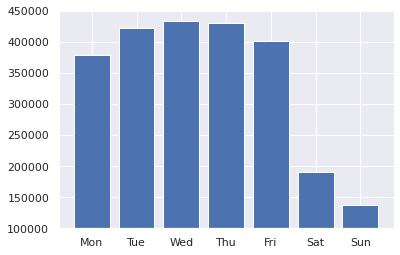

In [ ]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmbart.params[1:].tolist())
plt.ylim([100000,450000])

In [7]:
#2018 (dropped)
X2 = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=True)],axis=1)
X2 = sm.add_constant(X2) #use intercept instead of an exluded dummy for Monday; other dummies will be relative
lmbart=sm.OLS(bart.passenger[365:730],X2[365:730]).fit()
print(lmbart.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     243.6
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          9.30e-132
Time:                        16:19:01   Log-Likelihood:                -4490.3
No. Observations:                 365   AIC:                             8997.
Df Residuals:                     357   BIC:                             9028.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.904e+05   1.64e+04     23.799      0.0

<BarContainer object of 7 artists>

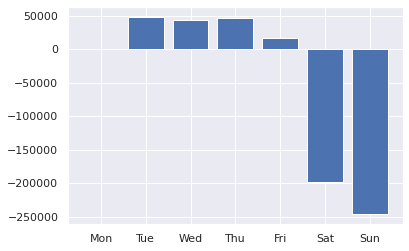

In [ ]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        [0] + lmbart.params[2:].tolist())

In [8]:
#2018
X2 = pd.concat([pd.DataFrame(range(bart.shape[0]),columns=['day']),pd.get_dummies(bart['DOW'],drop_first=False)],axis=1)
#X2 = sm.add_constant(X2) #use intercept instead of an exluded dummy for Monday; other dummies will be relative
lmbart=sm.OLS(bart.passenger[365:730],X2[365:730]).fit()
print(lmbart.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     243.6
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          9.30e-132
Time:                        16:19:05   Log-Likelihood:                -4490.3
No. Observations:                 365   AIC:                             8997.
Df Residuals:                     357   BIC:                             9028.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -34.0215     26.762     -1.271      0.2

(100000.0, 450000.0)

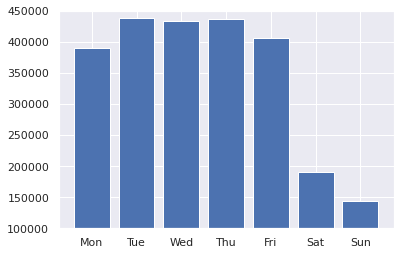

In [ ]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmbart.params[1:].tolist())
plt.ylim([100000,450000])

In [ ]:
bart2 = bart.set_index('date')
bart2.head()

,passenger,DOW
date,,
2017-01-01,122773,6
2017-01-02,139245,0
2017-01-03,366495,1
2017-01-04,388842,2
2017-01-05,407099,3


In [ ]:
#bart2 = bart2.asfreq('D')
bart2.index

Index(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04', '2017-01-05',
       '2017-01-06', '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
       ...
       '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25', '2019-12-26',
       '2019-12-27', '2019-12-28', '2019-12-29', '2019-12-30', '2019-12-31'],
      dtype='object', name='date', length=1095)

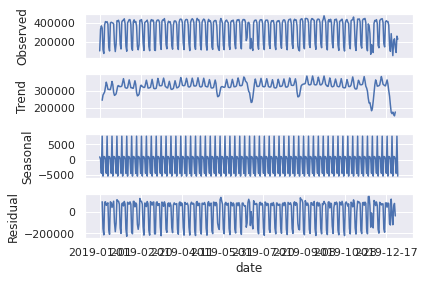

In [ ]:
bart2019 = bart2.iloc[730:1095]
bartDecomp = seasonal_decompose(bart2019['passenger'], model='additive', freq=6)
fig = bartDecomp.plot()

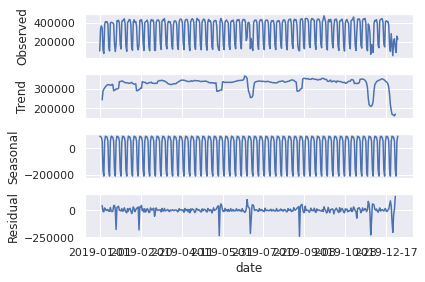

In [ ]:
bart2019 = bart2.iloc[730:1095]
bartDecomp = seasonal_decompose(bart2019['passenger'], model='additive', freq=7)
fig = bartDecomp.plot()

In [ ]:
from dateutil.parser import parse
df = pd.read_csv('https://raw.githubusercontent.com/CUSP2021ADS/Data/main/bart.csv', parse_dates=['date'], index_col='date')

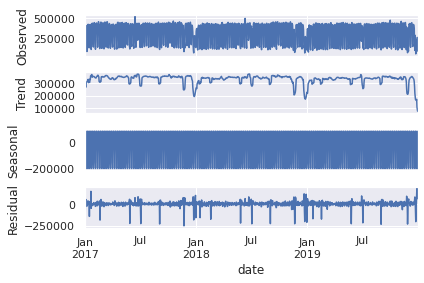

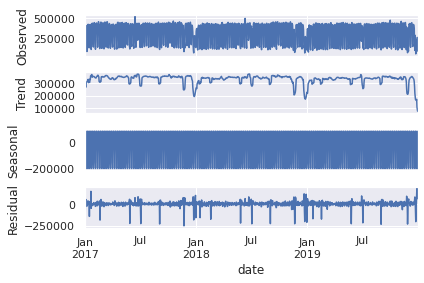

In [ ]:
result_add = seasonal_decompose(df['passenger'], model='additive', extrapolate_trend='freq')
result_add.plot()

In [ ]:
bart2019.head()

,date,passenger,DOW
730,2019-01-01,100098,1
731,2019-01-02,329733,2
732,2019-01-03,366644,3
733,2019-01-04,342706,4
734,2019-01-05,113495,5


In [9]:
lmbart=sm.OLS(bart.passenger[730:],X[730:]).fit()
print(lmbart.summary())

                            OLS Regression Results                            
Dep. Variable:              passenger   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     237.6
Date:                Mon, 21 Feb 2022   Prob (F-statistic):          3.60e-130
Time:                        16:19:15   Log-Likelihood:                -4503.1
No. Observations:                 365   AIC:                             9022.
Df Residuals:                     357   BIC:                             9053.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
day          -27.4152     27.716     -0.989      0.3

(100000.0, 450000.0)

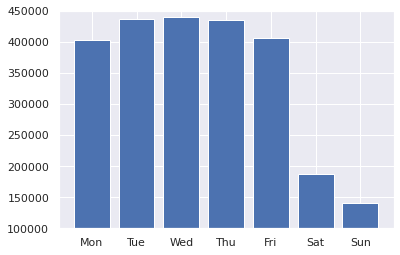

In [ ]:
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], 
        lmbart.params[1:].tolist())
plt.ylim([100000,450000])

Task 4: plot results and report in-sample (2017-2018) and out-of-sample (2019) predictions (same plot, different colors). Report in-sample and out-of-sample R-squared

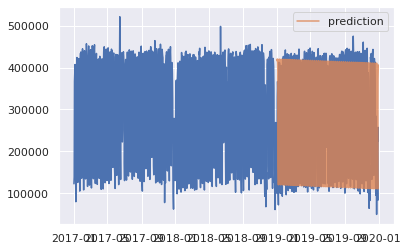

In [24]:
y = lmbart.predict(X[730:])
plt.plot(bart.date,bart.passenger)
plt.plot(bart.date[730:],y,label='prediction',alpha=0.8)
plt.legend()

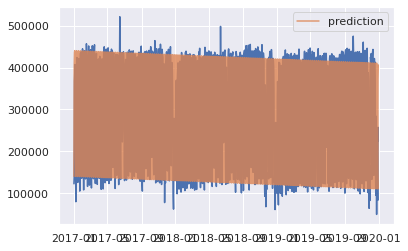

In [31]:
y = lmbart.predict(X)
plt.plot(bart.date,bart.passenger)
plt.plot(bart.date,y,label='prediction',alpha=0.8)
plt.legend()

In [33]:
r2_score(bart.passenger[:730],y[:730])

0.8275649226343542

In [34]:
r2_score(bart.passenger[730:],y[730:])

0.8232620926383054

Task 5: Use the "multiplicative" seasonal_decompose with 7 day period to decompose the BART data and detect outliers based on the top and bottom 2.5% of the residuals

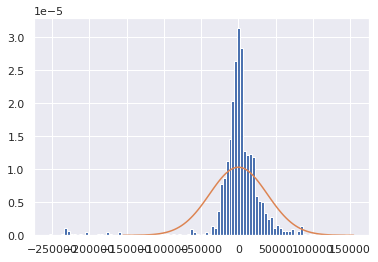

In [40]:
from numpy.random import seed
from numpy.random import randn

addResult = seasonal_decompose(bart.passenger, model='additive', freq=7)
residualAdd = np.array(addResult.resid)
residualAdd = residualAdd[np.logical_not(np.isnan(residualAdd))]
# get rid of nan values from the seasonal_decompose
plt.hist(residualAdd,bins=100,density=True)
sigma=residualAdd.std()
x=np.linspace(-4*sigma+residualAdd.mean(),4*sigma+residualAdd.mean(),100)
# seed the random number generator
seed(1)
plt.plot(x,scipy.stats.norm.pdf(x,loc=residualAdd.mean(),scale=sigma))
plt.show()

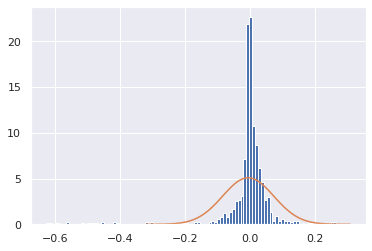

In [41]:
from numpy.random import seed
from numpy.random import randn

multResult = seasonal_decompose(bart.passenger, model='multiplicative', freq=7)
residualMult = np.log10(np.array(multResult.resid))
residualMult = residualMult[np.logical_not(np.isnan(residualMult))]
# get rid of nan values from the seasonal_decompose
plt.hist(residualMult,bins=100,density=True)
sigma=residualMult.std()
x=np.linspace(-4*sigma+residualMult.mean(),4*sigma+residualMult.mean(),100)
# seed the random number generator
seed(1)
plt.plot(x,scipy.stats.norm.pdf(x,loc=residualMult.mean(),scale=sigma))
plt.show()

In [42]:
scipy.stats.kstest(residualAdd, 'norm')

KstestResult(statistic=0.5399449035812672, pvalue=1.098712184381353e-297)

In [43]:
scipy.stats.kstest(residualMult, 'norm')

KstestResult(statistic=0.439366161604441, pvalue=6.935468296881817e-192)

In [44]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
# seed the random number generator
seed(1)
# normality test
stat, p = shapiro(residualAdd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.667, p=0.000
Sample does not look Gaussian (reject H0)


In [45]:
#for comparison try on the actual normal distribution
seed(1)
stat, p = shapiro(np.random.normal(0,1,size=500)); p

0.753082275390625

In [46]:
# D'Agostino and Pearson's Test
from scipy.stats import normaltest
# seed the random number generator
seed(1)
# normality test
stat, p = normaltest(residualAdd)
print('Statistics=%.3f, p=%.3f' % (stat, p))
# interpret
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=787.462, p=0.000
Sample does not look Gaussian (reject H0)


In [47]:
# Anderson-Darling Test
from scipy.stats import anderson
# seed the random number generator
seed(1)
# normality test
result = anderson(residualAdd)
print('Statistic: %.3f' % result.statistic)
p = 0
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    if result.statistic < result.critical_values[i]:
        print('%.3f: %.3f, data looks normal (fail to reject H0)' % (sl, cv))
    else:
        print('%.3f: %.3f, data does not look normal (reject H0)' % (sl, cv))

Statistic: 88.920
15.000: 0.574, data does not look normal (reject H0)
10.000: 0.654, data does not look normal (reject H0)
5.000: 0.784, data does not look normal (reject H0)
2.500: 0.915, data does not look normal (reject H0)
1.000: 1.088, data does not look normal (reject H0)


In [49]:
daySeries = bart['passenger']
dailyDecomp = seasonal_decompose(daySeries, model='multicative', freq=7)
residualMult = np.array(dailyDecomp.resid)
resMult = dailyDecomp.resid
#fig = dailyDecomp.plot();

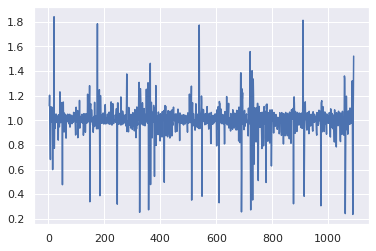

In [50]:
# normalize residual by log-transform
#logResid = np.log(dailyDecomp.resid/daySeries.values)
plt.show()
plt.plot(resMult);

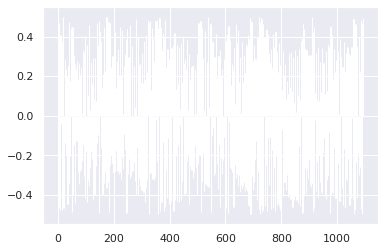

In [51]:
# based on percentile rank
outlierData = pd.DataFrame()
outlierData['Res'] = residualMult
outlierData['Percentile_rank'] = outlierData.Res.rank(pct = True)-0.5
plt.bar(np.arange(0, len(outlierData)), outlierData['Percentile_rank'], color='red')
plt.show()

In [54]:
# There is no certain definition of outliers, common methods include percentile, standard deviation, and IQR.
# In this case, we select 2.5% outliers.
bart.date[outlierData['Percentile_rank']>0.475]

20     2017-01-21
147    2017-05-28
175    2017-06-25
280    2017-10-08
323    2017-11-20
324    2017-11-21
328    2017-11-25
329    2017-11-26
350    2017-12-17
356    2017-12-23
363    2017-12-30
364    2017-12-31
384    2018-01-20
511    2018-05-27
539    2018-06-24
687    2018-11-19
688    2018-11-20
692    2018-11-24
720    2018-12-22
721    2018-12-23
727    2018-12-29
728    2018-12-30
732    2019-01-03
910    2019-06-30
1058   2019-11-25
1059   2019-11-26
1086   2019-12-23
1091   2019-12-28
Name: date, dtype: datetime64[ns]

In [56]:
bart.date[outlierData['Percentile_rank']<-0.475]

15     2017-01-16
50     2017-02-20
148    2017-05-29
184    2017-07-04
246    2017-09-04
326    2017-11-23
358    2017-12-25
365    2018-01-01
379    2018-01-15
414    2018-02-19
512    2018-05-28
549    2018-07-04
610    2018-09-03
690    2018-11-22
691    2018-11-23
723    2018-12-25
730    2019-01-01
735    2019-01-06
750    2019-01-21
778    2019-02-18
797    2019-03-09
876    2019-05-27
914    2019-07-04
974    2019-09-02
1061   2019-11-28
1062   2019-11-29
1088   2019-12-25
Name: date, dtype: datetime64[ns]